In [26]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2,cv2

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
pycocotools 2.0.2
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
detectron2 0.2.1
cv2 4.4.0


In [28]:
# ! pip install detectron2

In [1]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import numpy as np
import cv2
import random
import itertools
import pandas as pd
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [2]:
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT, K12AI_NBDATA_ROOT, K12AI_PRETRAINED_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook
k12ai_set_notebook(cellw=95)

## Read Data

In [3]:
dataset = 'faces'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, "imgs")
output_dir = os.path.join(K12AI_NBDATA_ROOT, 'cv', 'det', 'ouput')

df = pd.read_csv(os.path.join(data_root, 'annotations.csv'))
df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,face_0.jpeg,650,333,56,102,112,151,face
1,face_0.jpeg,650,333,379,97,428,156,face
2,face_1.jpeg,1280,697,903,162,985,252,face
3,face_2.jpeg,460,240,216,12,279,80,face
4,face_2.jpeg,460,240,289,2,343,74,face


## Train/Val Sample

In [ ]:
unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.8), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

In [ ]:
classes = df.class_name.unique().tolist()
classes

In [ ]:
def create_dataset_dicts(df, classes):
    dataset_dicts = []
    for image_id, img_name in enumerate(df.file_name.unique()):

        record = {}

        image_df = df[df.file_name == img_name]

        file_path = f'{imgs_path}/{img_name}'
        # if not os.path.exists(file_path):
        #     print(file_path)
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)

        objs = []
        for _, row in image_df.iterrows():

            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)

            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(row.class_name),
                "iscrowd": 0
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
len(train_df.file_name.unique()), len(test_df.file_name.unique())

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
    MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")
statement_metadata

In [ ]:
class CocoTrainer(DefaultTrainer):
  
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        os.makedirs(output_dir, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, distributed=False, output_dir=output_dir)

In [5]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = os.path.join(f'{K12AI_PRETRAINED_ROOT}/cv/model_zoo/model_final_68b088.pkl')

cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # len(classes)

cfg.TEST.EVAL_PERIOD = 500

cfg.OUTPUT_DIR = output_dir

os.makedirs(output_dir, exist_ok=True)

In [ ]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
test_image_paths = test_df.file_name.unique()
test_image_paths

In [ ]:
for clothing_image in test_image_paths[:2]:
    file_path = f'{imgs_path}/{clothing_image}'
    im = cv2.imread(file_path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=statement_metadata, 
        scale=1., 
        instance_mode=ColorMode.IMAGE
    )
    instances = outputs["instances"].to("cpu")
    instances.remove('pred_masks')
    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    file_name = os.path.basename(clothing_image)
    write_res = cv2.imwrite(f'{output_dir}/{file_name}', result)

In [ ]:
annotated_images = [f'{output_dir}/{f}' for f in test_df.file_name.unique()]
annotated_images[:2]

In [ ]:
plt.figure(figsize=(16, 12))

img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [ ]:
im = cv2.imread(f'{output_dir}/test.jpg')
outputs = predictor(im)
v = Visualizer(
    im[:, :, ::-1],
    scale=1., 
    instance_mode=ColorMode.IMAGE
)
instances = outputs["instances"].to("cpu")
instances.remove('pred_masks')
v = v.draw_instance_predictions(instances)
# result = v.get_image()[:, :, ::-1]
# cv2.imwrite(f'{output_dir}/test_det.jpg', result)

# plt.figure(figsize=(10, 16))
# img = cv2.cvtColor(cv2.imread(f'{output_dir}/test_det.jpg'), cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.axis('off');

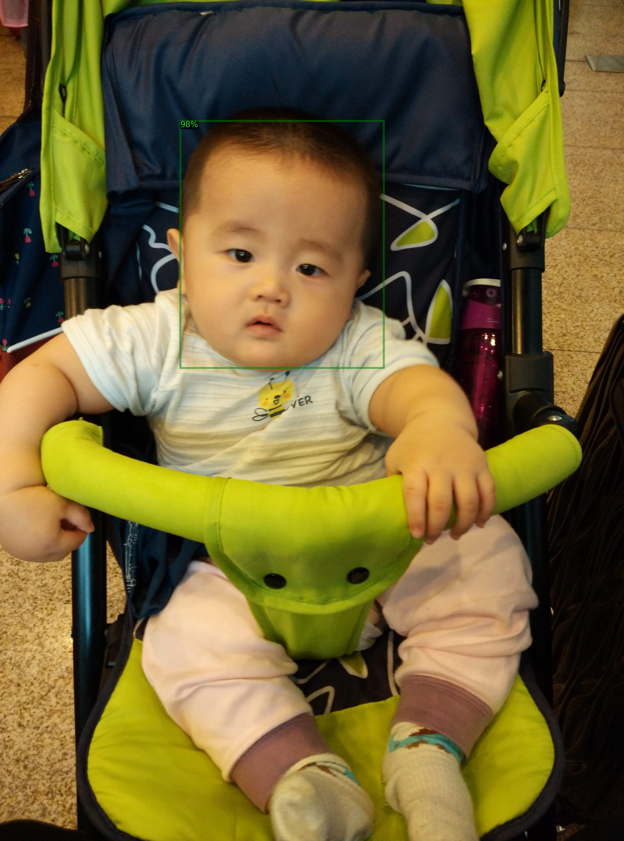

In [25]:
img = Image.fromarray(v.get_image())
img.resize((int(0.2*img.size[0]), int(0.2*img.size[1])))